# Titanic

## https://www.kaggle.com/competitions/titanic

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import joblib

In [2]:
from sklearn.pipeline import Pipeline
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

from sklearn.compose import ColumnTransformer
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

from sklearn.model_selection import GridSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Analize Data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

## Correlation

In [4]:
# Load data
df = pd.read_csv('data_train.csv')

In [5]:
train_corre = df[['Age','SibSp','Parch','Fare','Survived']]
# corre = train_corre.corr().sort_values('Survived', ascending=False)
corre = train_corre.corr().sort_values('Survived', ascending=False)[['Survived']]
corre

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
SibSp,-0.035322
Age,-0.077221


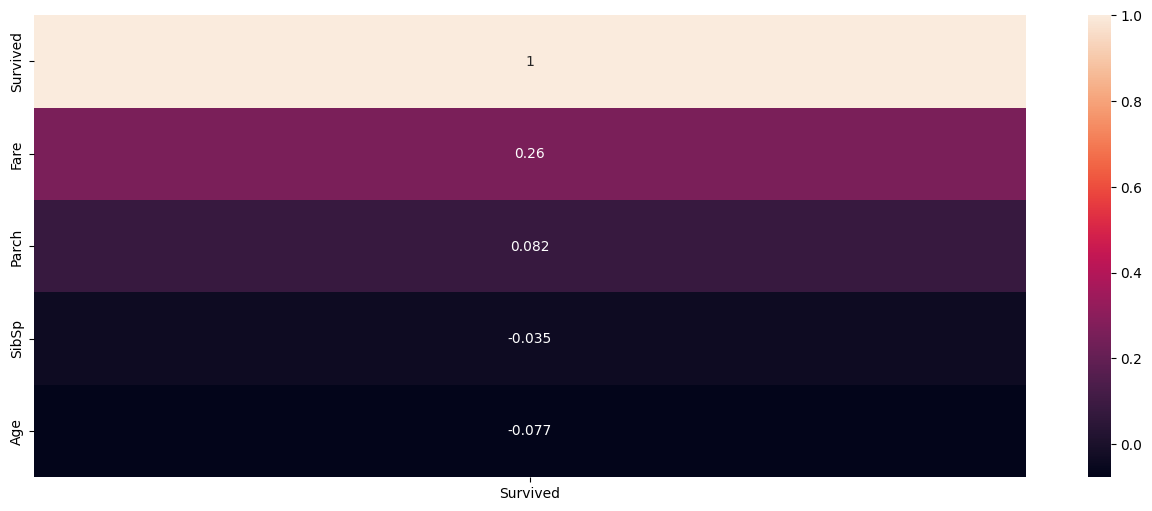

In [6]:
plt.figure(figsize=(16,6))
sns.heatmap(data=corre, annot=True)
plt.show()

## Compare surviving passengers

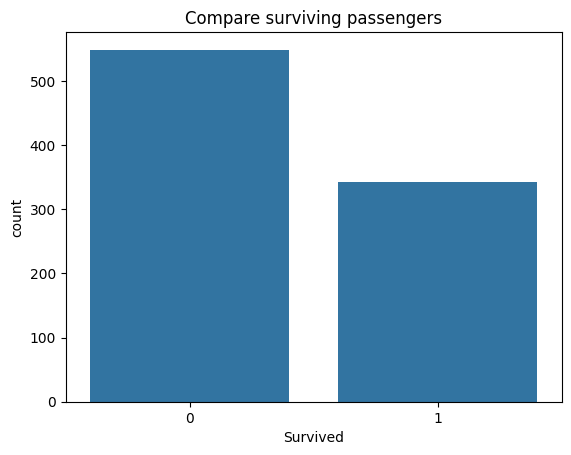

In [7]:
sns.countplot(data=df, x="Survived")
plt.title('Compare surviving passengers')
plt.show()

## Compare surviving passengers (Age)

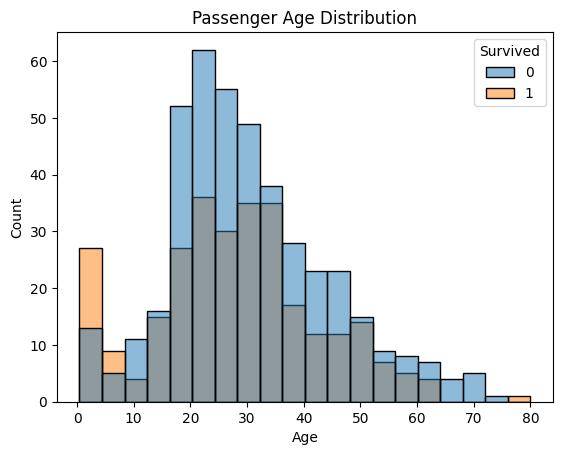

In [8]:
# Membuat visualisasi distribusi umur penumpang
sns.histplot(data=df, x="Age", bins=20, hue = 'Survived')
plt.title('Passenger Age Distribution')
plt.show()

## Compare surviving passengers (Sex)

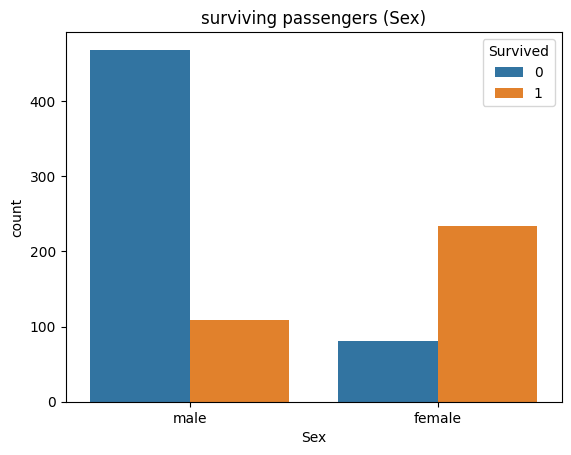

In [9]:
# # Membuat visualisasi jumlah penumpang berdasarkan jenis kelamin

vis = df.copy()

# Mengubah tipe data menjadi string
vis['Sex'] = vis['Sex'].astype('str')
vis['Survived'] = vis['Survived'].astype('str')

# Membuat visualisasi
sns.countplot(data=vis, x="Sex", hue='Survived')
plt.title('surviving passengers (Sex)')
plt.show()

del vis

## Compare surviving passengers (Sex and Age)

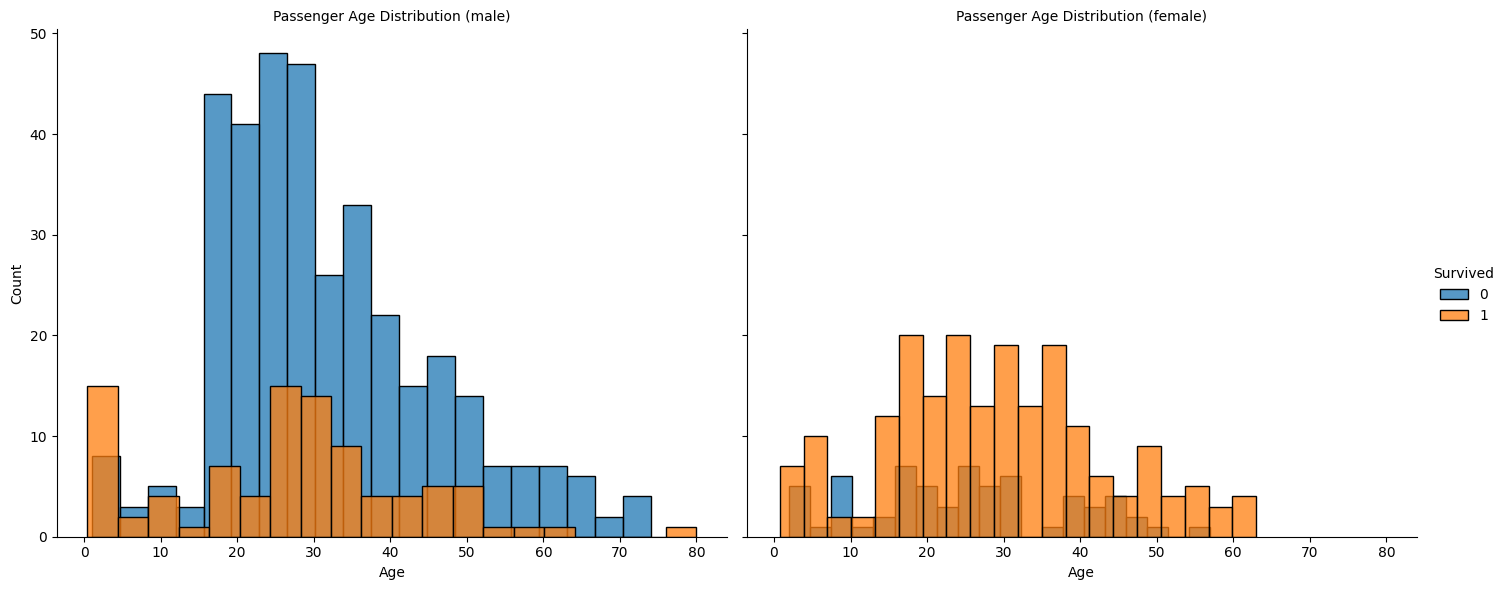

In [10]:
g = sns.FacetGrid(df, col="Sex", hue="Survived", height=6, aspect=1.2)
g.map(sns.histplot, "Age", bins=20)

g.set_titles("Passenger Age Distribution ({col_name})")

g.add_legend()

plt.show()

## There are indications that women and children are more likely to survive

In [11]:
def umur(x):
    if x <= 12:
        return "1"
    elif x >= 13 and x <= 18:
        return "2"
    elif x >= 19 and x <= 40:
        return "3"
    elif x >= 41 and x <= 65:
        return "4"    
    else:
        return "5"
    
def new_feature(df):
    df['umur'] = df['Age'].apply(lambda x : umur(x))
    df['WA'] = 0
    df.loc[(df['umur'] == '1') | (df['Sex'] == 'female'), 'WA'] = 1

    return df

df = new_feature(df)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,umur,WA
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3,0


# Split

In [12]:
# Split data
X = df[['Pclass', 'Sex', 'Embarked', 'Age', 'SibSp', 'Parch', 'Fare', 'umur', 'WA']]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'umur', 'WA']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Create Pipeline, Grid Search CV and Train Data

In [13]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [14]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [16]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

In [17]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__class_weight': ['balanced', {0: 2, 1: 1}],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [18]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'umur',
                                                                          'WA']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__class_weight': ['balanced',
                                                      {0: 2, 1: 1}]})

In [19]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'classifier__C': 0.1, 'classifier__class_weight': 'balanced'}
Best cross-validation score: 0.82


In [20]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_model.joblib')
print('done')

done


# Simple Test

In [21]:
data_dict = {
    'Pclass': 3,
    'Name': 'Braund, Mr. Owen Harris',
    'Sex': 'male',
    'Age': 22,
    'SibSp': 1,
    'Parch': 0,
    'Ticket': 'A/5 21171',
    'Fare': 7.25,
    'Cabin': None,
    'Embarked': 'S'
}

In [22]:
new_data = pd.DataFrame([data_dict])
new_data = new_feature(new_data)
new_data.drop(['Name','Cabin','Ticket'], axis=1, inplace=True)

In [23]:
import joblib

loaded_model = joblib.load('best_model.joblib')
predictions = loaded_model.predict(new_data)

print(predictions)

[0]


# X_test dan y_test

In [24]:
# X_test.head()

In [25]:
y_pred = loaded_model.predict(X_test)
# y_pred

In [26]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.77


# Submission

In [27]:
df_sub = pd.read_csv('data_test.csv')
df_sub = new_feature(df_sub)
df_sub_asli = df_sub.copy()

In [28]:
df_sub.drop(['Name','Cabin','Ticket','PassengerId'], axis=1, inplace=True)

In [29]:
predictions_sub = loaded_model.predict(df_sub)

In [30]:
df_sub_asli.reset_index(drop=True, inplace=True)
df_sub_asli = pd.concat([df_sub_asli, pd.Series(predictions_sub, name='Survived')], axis=1)
# df_sub_asli.head()

In [31]:
df_sub_asli = df_sub_asli[['PassengerId','Survived']]
# df_sub_asli.head()

In [32]:
df_sub_asli.to_csv('hasil_prediksi_3.csv', index=False)